In [23]:
# !pip install --upgrade sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import plotly.express as px
from itertools import product
import warnings
import statsmodels.api as sm
plt.style.use('seaborn-darkgrid')
import pandas as pd
import numpy as np
import glob
import xarray as xr

idx = pd.IndexSlice

root_path = r'/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/'
_thudohanoi_data_path = r'/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data'
_thudohanoi_files = glob.glob(_thudohanoi_data_path + '/*.csv')

thudohanoi_df = pd.DataFrame()
for file in _thudohanoi_files:
    print('Currently processing file \n{}'.format(file))
    thudohanoi_df = thudohanoi_df.append(pd.read_csv(file, parse_dates=True, index_col=['site_id', 'time'],
                                                    dtype={'CO': np.float64, 'NO2': np.float64,'PM25': np.float64,
                                                          'AQI_h': np.float64, 'AQI_h_I': np.int, 'site_id': np.int}))
    
# Remove site 16 because of some inconsistency in data
# thudohanoi_df = thudohanoi_df[(thudohanoi_df.index.get_level_values(0) != 49)]
thudohanoi_df = thudohanoi_df[['PM25']]

Currently processing file 
/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data/30.csv
Currently processing file 
/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data/9.csv
Currently processing file 
/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data/32.csv
Currently processing file 
/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data/11.csv
Currently processing file 
/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data/40.csv
Currently processing file 
/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data/28.csv
Currently processing file 
/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data/49.csv
Currently processing file 
/

In [27]:
# make the data stationary
# First establish the stationary test
# Second make a transformer for data to be stationary
# Third make a inverse transformer to transform data back to original
# test the data with 3 regression model first and one deep model.
def create_data(thudohanoi_df, site):
    from sklearn.preprocessing import MinMaxScaler
    thudo_copy = thudohanoi_df[thudohanoi_df.index.get_level_values(0) == site].copy()
    thudo_copy = thudo_copy.reset_index(level=0, drop=True)
    thudo_copy = thudo_copy.asfreq('h')
    test_series = thudo_copy['PM25']
    series = pd.Series(test_series, index=test_series.index).interpolate(method='linear').ffill().bfill()
    scaler = MinMaxScaler((-1,1))
    series = scaler.fit_transform(series.values.reshape(-1, 1))
    return series

def adf_test(series):
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1]<0.05:
        print("Series is stationary")
    else:
        print("Series is not stationary")
    return None
    

site_ids = thudohanoi_df.index.get_level_values(0).unique()
for site in site_ids:
    print("======================\nSite {}".format(site))
    series = create_data(thudohanoi_df, site)
    adf_test(series)
    

Site 30
ADF Statistic: -5.862845
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Series is stationary
Site 9
ADF Statistic: -5.769575
p-value: 0.000001
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Series is stationary
Site 32
ADF Statistic: -5.623751
p-value: 0.000001
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Series is stationary
Site 11
ADF Statistic: -4.854879
p-value: 0.000043
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Series is stationary
Site 40
ADF Statistic: -5.167566
p-value: 0.000010
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Series is stationary
Site 28
ADF Statistic: -5.284048
p-value: 0.000006
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Series is stationary
Site 49
ADF Statistic: -13.170923
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Series is stationary
Site 46
ADF Statistic: -5.605368
p-value: 0.000001
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Series is sta

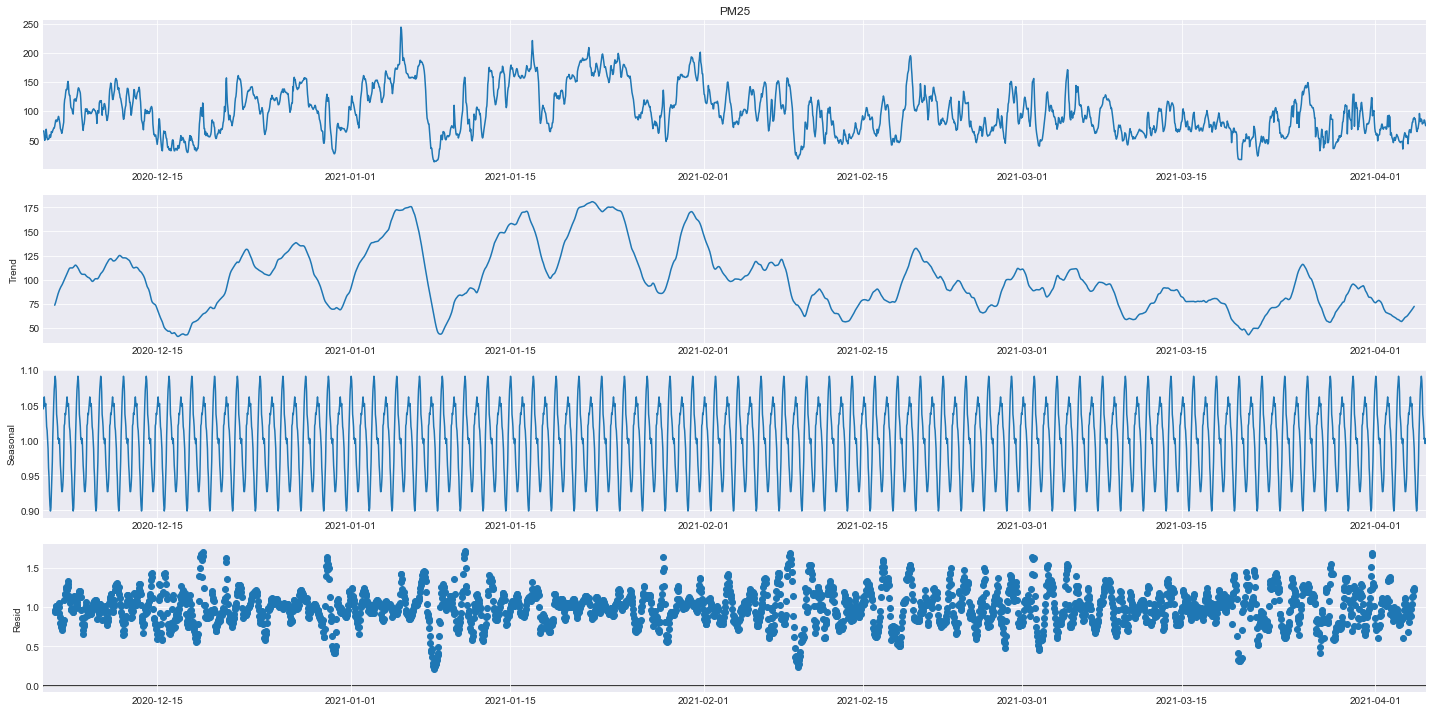

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
# test_series = thudo_copy.loc[thudo_copy.index.year < 2019, 'PM25']
test_series = thudo_copy['PM25']
series = pd.Series(test_series, index=test_series.index).interpolate(method='linear').ffill().bfill()
results = seasonal_decompose(series, model='multiplicative', period=48)
plt.rcParams['figure.figsize'] = (20.0, 10.0)
results.plot()
plt.show()

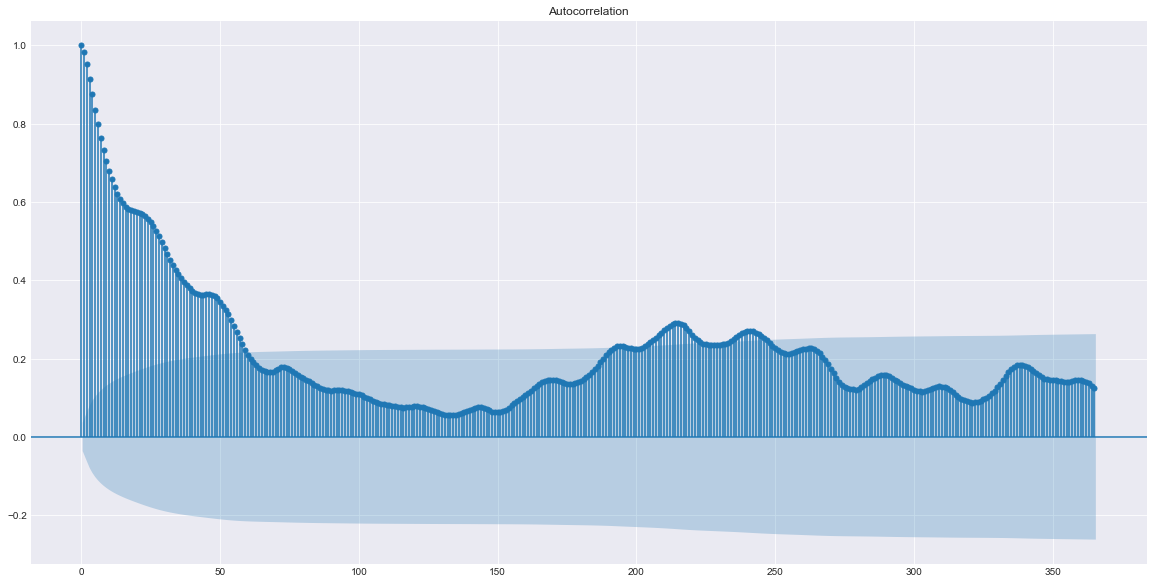

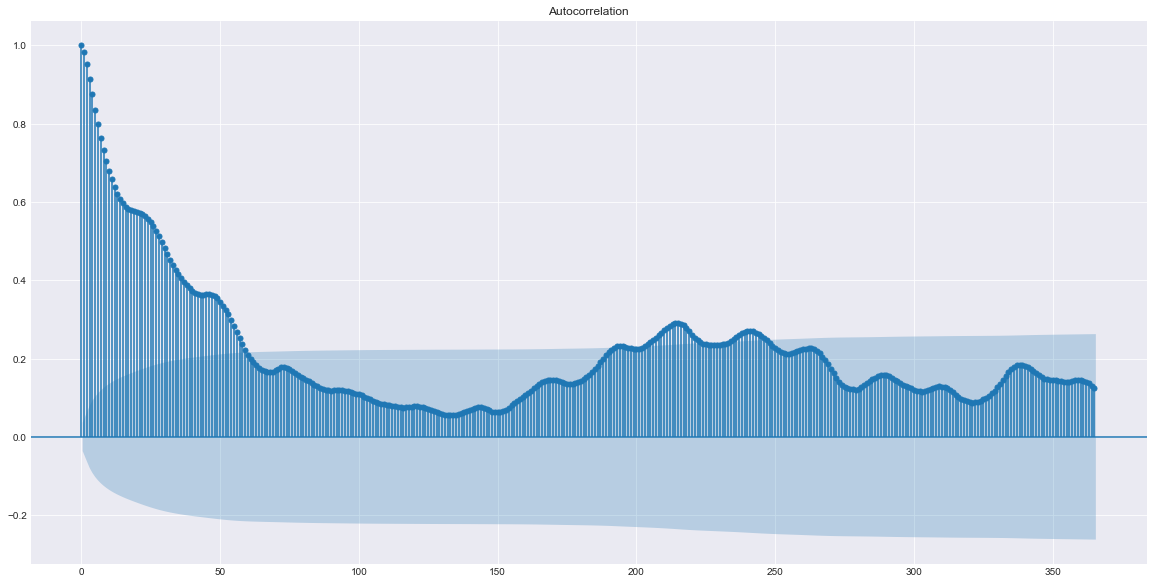

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(series,lags= 365)

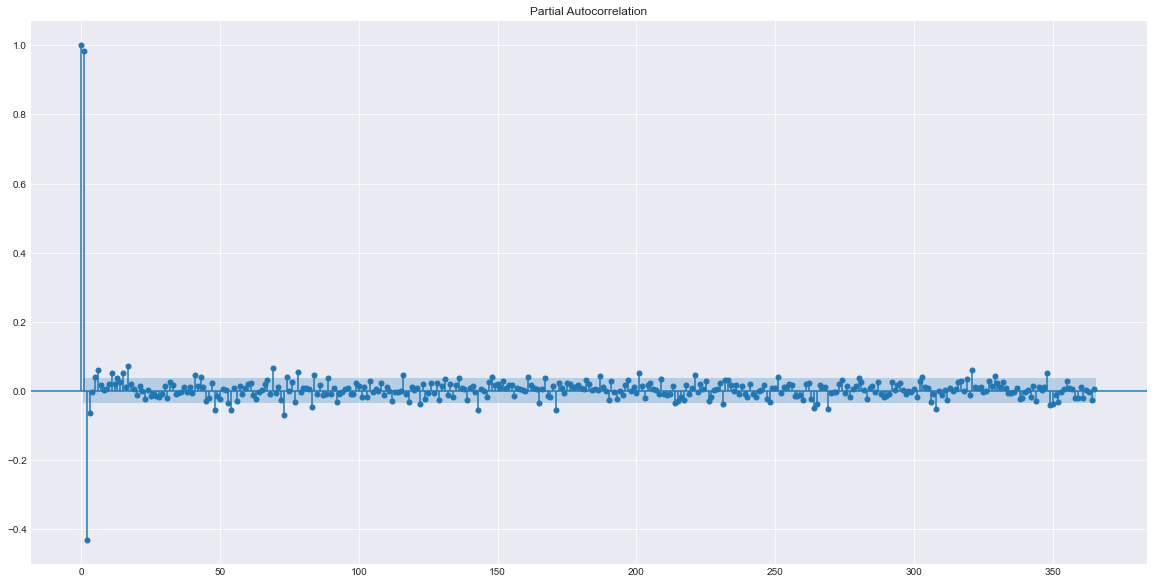

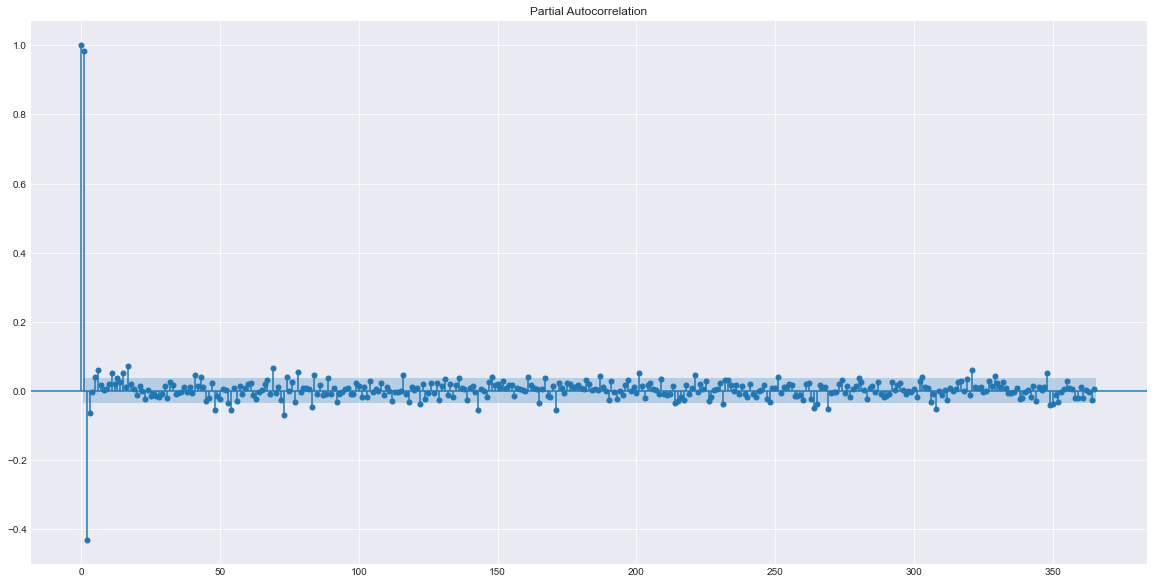

In [18]:
plot_pacf(series,lags= 365)

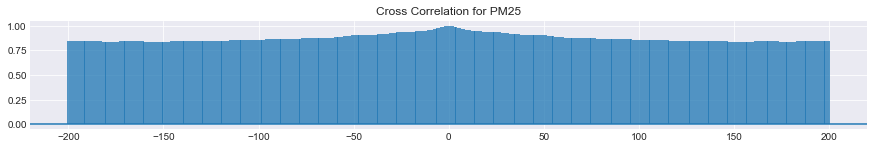

In [20]:
plt.figure(figsize=(15,2)) # add this statement before your plot
plt.xcorr(series.values,series.values,maxlags=200, usevlines=1)
plt.title('Cross Correlation for PM25')
plt.show()